In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
from  gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=6, height=6, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, 1, x] = 1
    normals[0, 1, y] = 1
#     normals[0, -1, x] = 1
#     normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
#     forces[0, 0, x] = 1
    forces[-1, rd, x] = -1
    return normals, forces, density

In [3]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [4]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [5]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [6]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [7]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [8]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [9]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [10]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [11]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [12]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), {}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [13]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [14]:
# ts=5e6
ts=3e6

In [15]:
# Create log dir
log_dir = "/tmp/gym6c231/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [16]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [17]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 3000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 5000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 7000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 9000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10000
Best mean reward: 0.00 - Last mean reward p

Num timesteps: 96000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 97000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 98000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 99000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 100000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 101000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 102000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 103000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 104000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 105000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 106000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 107000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10800

Num timesteps: 196000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 197000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 198000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 199000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 200000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 201000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 202000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 203000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 204000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 205000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 206000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 207000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 2

Num timesteps: 296000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 297000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 298000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 299000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 300000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 301000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 302000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 303000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 304000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 305000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 306000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 307000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 3

Num timesteps: 373000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 374000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 375000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 376000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 377000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 378000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 379000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 380000
Best mean reward: 0.00 - L

Num timesteps: 445000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 446000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 447000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 448000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 449000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 450000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 451000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 452000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 453000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 454000
Best mean reward: 0.01 -

Num timesteps: 533000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 534000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 535000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 536000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 537000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 538000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 539000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 540000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 541000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 542000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 543000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 544000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5

Num timesteps: 633000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 634000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 635000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 636000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 637000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 638000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 639000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 640000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 641000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 642000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 643000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 644000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6

Num timesteps: 727000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 728000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 729000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 730000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 731000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 732000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 733000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 734000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 735000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 736000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 737000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 738000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7

Num timesteps: 827000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 828000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 829000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 830000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 831000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 832000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 833000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 834000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 835000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 836000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 837000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 838000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8

Num timesteps: 927000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 928000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 929000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 930000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 931000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 932000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 933000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 934000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 935000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 936000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 937000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 938000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9

Num timesteps: 1026000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1027000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1028000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1029000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1030000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1031000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1032000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1033000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1034000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1035000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1036000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1037000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1125000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1126000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1127000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1128000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1129000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1130000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1131000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1132000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1133000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1134000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1135000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1136000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1224000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1225000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1226000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1227000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1228000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1229000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1230000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1231000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1232000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1233000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1234000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1235000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1323000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1324000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1325000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1326000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1327000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1328000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1329000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1330000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1331000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1332000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1333000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 1334000
Best mean 

Num timesteps: 1416000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 1417000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 1418000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1419000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1420000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1421000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1422000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1423000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1424000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1425000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1426000
Best mean reward: 0.01 - Last mean rewa

Num timesteps: 1512000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1513000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1514000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1515000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1516000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1517000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1518000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1519000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1520000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1521000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1522000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1523000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1611000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1612000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1613000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1614000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1615000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1616000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1617000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1618000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1619000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1620000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1621000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1622000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1710000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1711000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1712000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1713000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1714000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1715000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1716000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1717000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1718000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1719000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1720000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1721000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1809000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1810000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1811000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1812000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1813000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1814000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1815000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1816000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1817000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1818000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1819000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1820000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1908000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1909000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1910000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1911000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1912000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1913000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1914000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1915000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1916000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1917000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1918000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1919000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2007000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2008000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2009000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2010000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2011000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2012000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2013000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2014000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2015000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2016000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2017000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2018000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2106000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2107000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2108000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2109000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2110000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2111000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2112000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2113000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2114000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2115000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2116000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2117000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2200000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2201000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2202000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2203000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2204000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2205000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2206000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2207000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2208000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2209000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2210000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2211000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2299000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2300000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2301000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2302000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2303000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2304000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2305000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2306000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2307000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2308000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2309000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2310000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2398000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2399000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2400000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2401000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2402000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2403000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2404000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2405000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2406000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2407000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2408000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2409000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2497000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2498000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2499000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2500000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2501000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2502000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2503000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2504000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2505000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2506000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2507000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2508000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2596000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2597000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2598000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2599000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2600000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2601000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2602000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2603000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2604000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2605000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2606000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2607000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2695000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2696000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2697000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2698000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2699000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2700000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2701000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2702000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2703000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2704000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2705000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2706000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2794000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2795000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2796000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2797000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2798000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2799000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2800000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2801000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2802000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2803000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2804000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2805000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2893000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2894000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2895000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2896000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2897000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2898000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2899000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2900000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2901000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2902000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2903000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2904000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2992000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2993000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2994000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2995000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2996000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2997000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2998000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2999000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3000000
Best mean reward: 0.01 - Last mean reward per episode: 0.01


In [18]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 64.87055126428604 min


### Inference

In [19]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()
obs=obs[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [20]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(int(action))
    if dones:
        break
    i+=1

In [21]:
print(i)

36



Final Cantilever beam design:


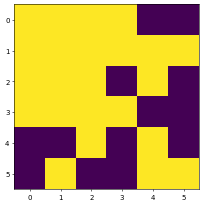

In [22]:
env.render()

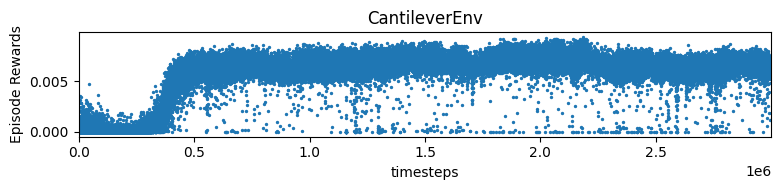

In [23]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [24]:
obs=env.reset()
obs=obs[0]

In [25]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [26]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    if dones:
        break
    i+=1

In [27]:
i

36


Final Cantilever beam design:


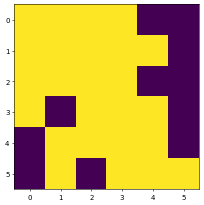

In [28]:
env.render()

In [29]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 